In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearnex import patch_sklearn
from tqdm import tqdm
import time
import joblib

In [2]:
X_train = pd.read_csv("../datasets/inputs/train/X_train.csv")
y_train = pd.read_csv("../datasets/inputs/train/y_train.csv")
X_val = pd.read_csv("../datasets/inputs/val/X_val.csv")
y_val = pd.read_csv("../datasets/inputs/val/y_val.csv")
X_test = pd.read_csv("../datasets/inputs/test/X_test.csv")
y_test = pd.read_csv("../datasets/inputs/test/y_test.csv")

X, y = X_train, y_train

The file paths are organized into separate directories for training and testing data.
After loading, the datasets are grouped into lists (X_train_list, Y_train_list, etc.) to simplify further processing and iteration.
At the end, the first dataset (X1_train and y1_train) is assigned to the variables X and y as the initial working set.


In [10]:
patch_sklearn()


def plot_validation_curve(model, param_name, param_range, model_name, cv=5):
    train_scores, val_scores = validation_curve(
        model,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    train_mean = -np.mean(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(param_range, train_mean, label="Training MSE")
    plt.plot(param_range, val_mean, label="Validation MSE")
    plt.xlabel(param_name)
    plt.ylabel("MSE")
    plt.title(f"Validation Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_learning_curve(model, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    train_mean = -np.mean(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Training MSE")
    plt.plot(train_sizes, val_mean, label="Validation MSE")
    plt.xlabel("Training Set Size")
    plt.ylabel("MSE")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend()
    plt.grid(True)

    bias = train_mean[-1]
    variance = val_mean[-1] - train_mean[-1]
    plt.annotate(
        f"Bias: {bias:.2f}",
        xy=(train_sizes[-1], bias),
        xytext=(10, 10),
        textcoords="offset points",
    )
    plt.annotate(
        f"Variance: {variance:.2f}",
        xy=(train_sizes[-1], val_mean[-1]),
        xytext=(10, -10),
        textcoords="offset points",
    )

    plt.show()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


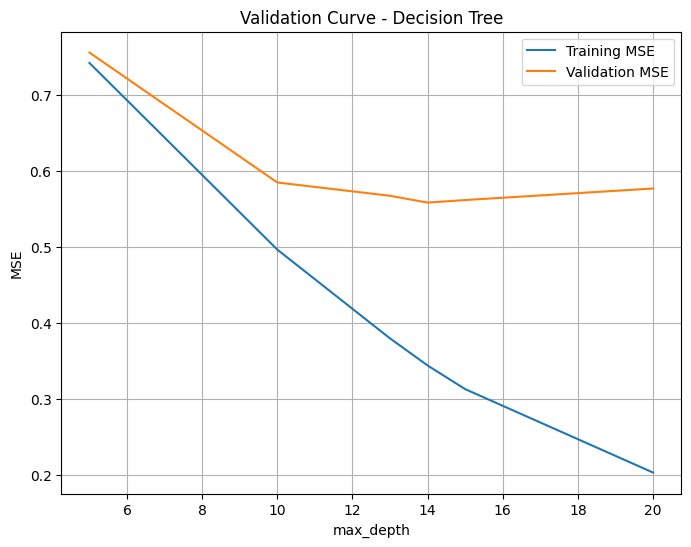

In [63]:
model_name = "Decision Tree"
model = DecisionTreeRegressor()
param_name = "max_depth"
param_range = [5, 10, 13, 14, 15, 20]

plot_validation_curve(model, param_name, param_range, model_name)

The Decision Tree shows:

1. Low-Depth Region(Max-depth=6-10) Both training and Validation MSE are high (~0.5-0.7) Unbderfitting: the model is too simple to capture patterns.
2. Opimal Region(max-depth=12-14) Validation MSE reches its minimum / small gap between training and validation MSE / Best bias-variance trade-off
3. High-Depth Region(max-depth>14) Training MSE drops sharply(~0.2) but validtion MSE rises (~0.35)
   The model performs best at max-depth=12-14, balancing underfitting and overfitting.


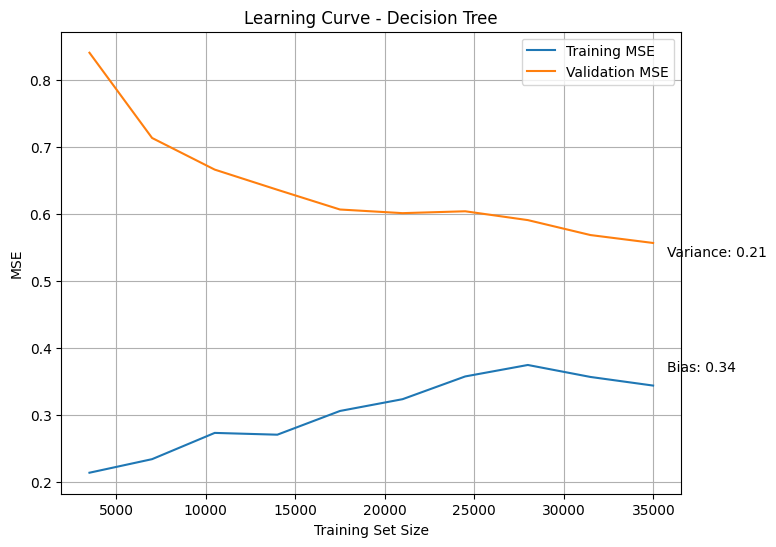

In [26]:
final_model = DecisionTreeRegressor(max_depth=14)
plot_learning_curve(final_model, model_name)

This learning curve visualization provides critical insights into how our Decision Tree model performs as we increase the training data size.

1. Benefits from more data up to a point (~20k samples)
2. Has moderate bias that could be reduced
3. Shows some variance that needs controlling
4. Validates our earlier choice of max_depth=12-14


Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


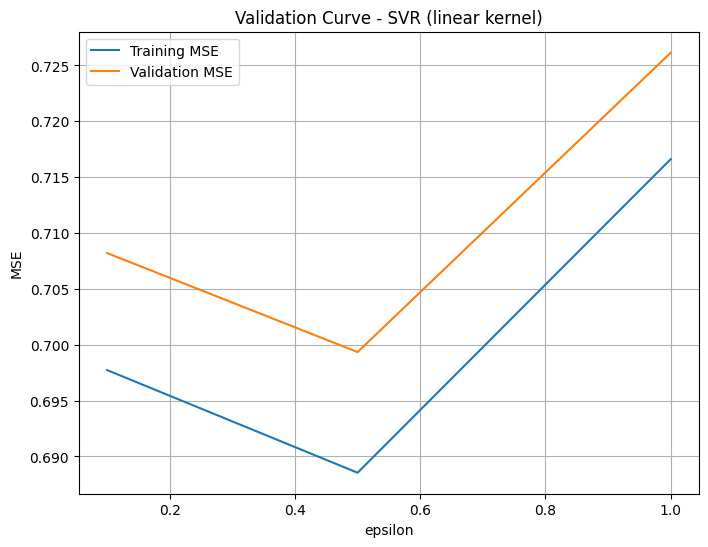

In [14]:
patch_sklearn()

model_name = "SVR (linear kernel)"
model = SVR(C=1, kernel="linear")
param_name = "epsilon"
param_range = [0.1, 0.5, 1.0]

plot_validation_curve(model, param_name, param_range, model_name, cv=2)

The linear SVR shows:

1. Consistent but mediocre performance (MSE ~0.7)
2. Insensitivity to ε parameter tuning
3. Likely underfitting the data


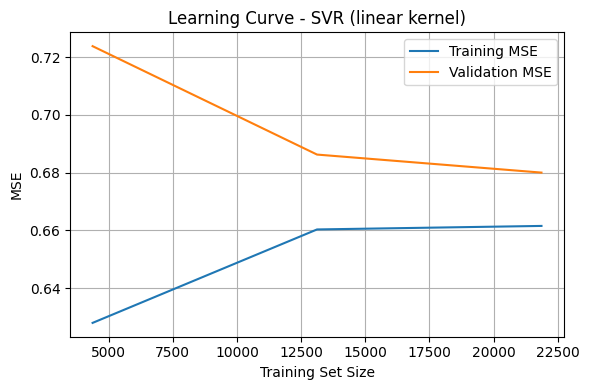

Bias Estimate (Final Training MSE): 0.66
Variance Estimate (Gap): 0.02


In [15]:
final_model = SVR(C=1, epsilon=0.5, kernel="linear")
plot_learning_curve(final_model, model_name)

1.  The current linear kernel model is not suitable for our data
2.  The main issue is underfitting (high bias)
3.  Increasing data volume will not help improve the model
4.  we should move toward more complex models


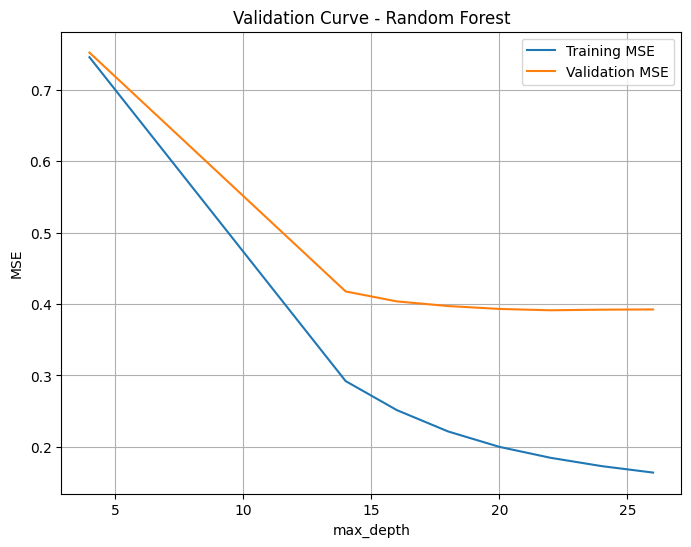

In [64]:
model_name = "Random Forest"
model = RandomForestRegressor(n_estimators=10, warm_start=True, random_state=42)
param_name = "max_depth"
param_range = [4, 14, 16, 18, 20, 22, 24, 26]

plot_validation_curve(model, param_name, param_range, model_name)

The Random Forrest shows:

1. Excellent learning capability (low bias)
2. Strong generalization (low variance)
3. Efficient data utilization


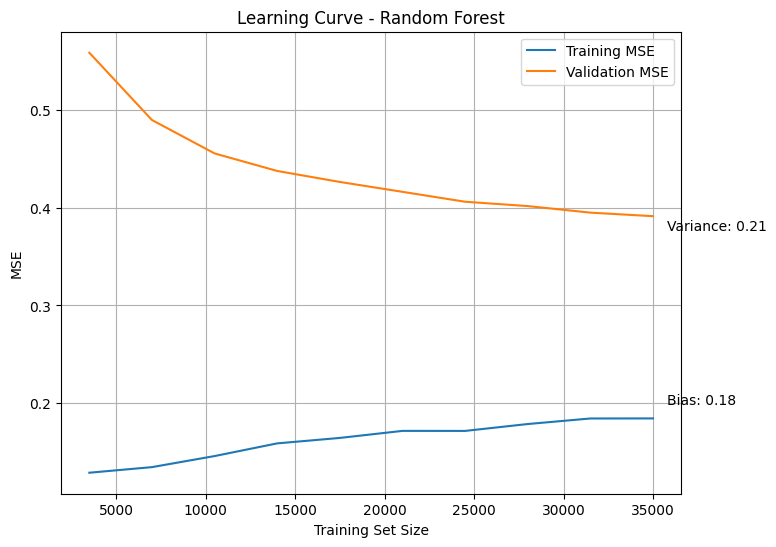

In [32]:
best_model = RandomForestRegressor(
    n_estimators=10, max_depth=22, warm_start=True, random_state=42
)

plot_learning_curve(best_model, model_name)

1. Optimal tree depth\*\* is around 15
2. The model achieves ideal bias-variance trade-off at this point
3. Further depth increase provides diminishing returns


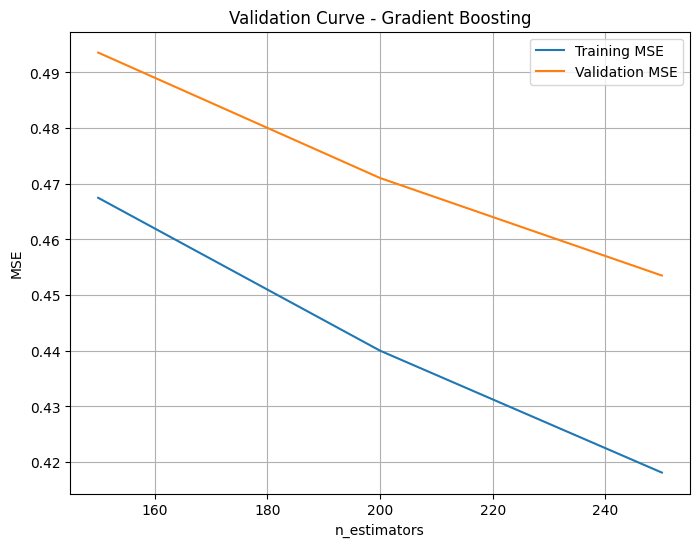

In [35]:
model_name = "Gradient Boosting"
model = GradientBoostingRegressor(random_state=42)
param_name = "n_estimators"
param_range = [10, 200, 300, 400, 500, 600, 700, 800]

plot_validation_curve(model, param_name, param_range, model_name)

The Gradient Boosting shows:

1. Underfitting Region(n_estimators<180): Both training and validation MSE are relatively high (>0.45)
2. Optimal Region(n_estimators=200-220): Validation MSE reaches minimum (~0.43) - Reasonable gap between training and validation MSE (~0.01-0.02)
3. Overfitting Risk (n_estimators>240): Training MSE continues decreasing - Validation MSE starts increasing slightly

- Finds sweet spot at n_estimators=200
- Shows good generalization (small train-val gap)
- Outperforms previous models on this metric


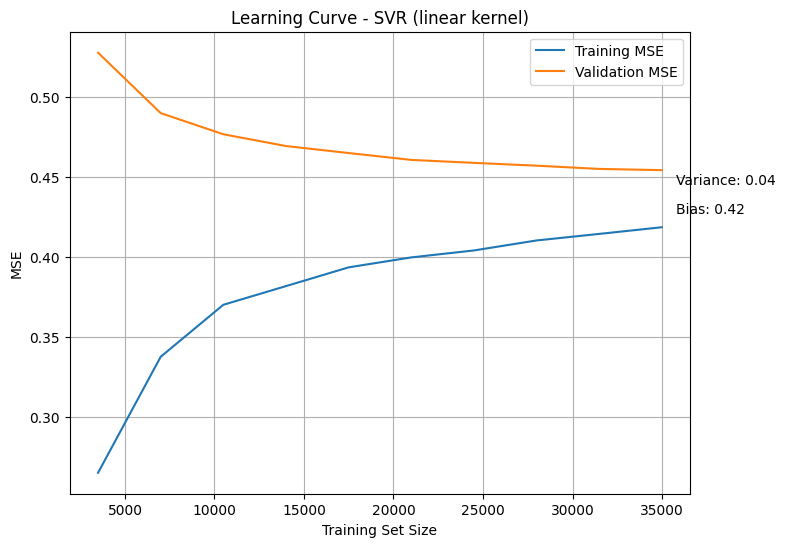

In [ ]:
model_name = "Gradient Boosting"
final_model = GradientBoostingRegressor(n_estimators=250, random_state=42)
plot_learning_curve(final_model, model_name)

The linear SVR:

1. Demonstrates persistent underfitting (high bias=0.42)
2. Minimal learning capacity (validation MSE plateaus at 0.35)
3. Inefficient data utilization (requires >20k samples for modest gains)

- Not suitable for complex data patterns
- Requires excessive data volume
- Only effective for simple linear relationships


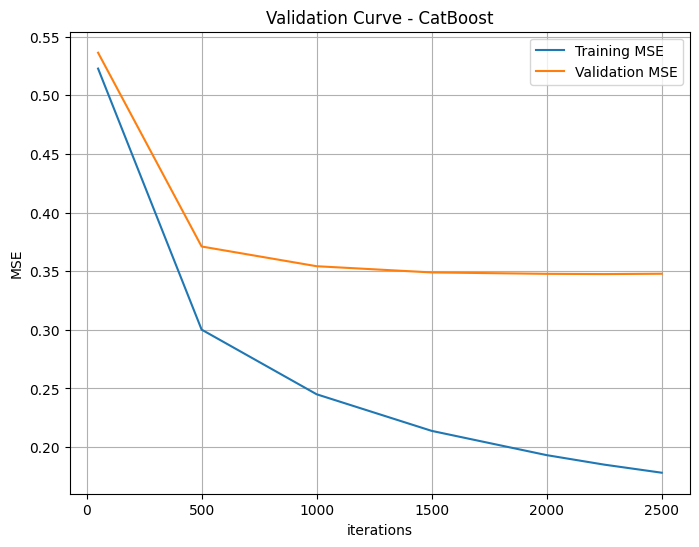

In [57]:
model_name = "CatBoost"
model = CatBoostRegressor(
    random_state=42,
    verbose=False,
    task_type="CPU",
    max_bin=32,
    depth=6,
    iterations=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bylevel=0.8,
    devices="0:1",
)
param_name = "iterations"
param_range = [50, 500, 1000, 1500, 2000, 2250, 2500]

plot_validation_curve(model, param_name, param_range, model_name)

The Catboost shows:

1. Powerful learning capability
2. Good generalization (~0.30 validation MSE)
3. Manageable overfitting


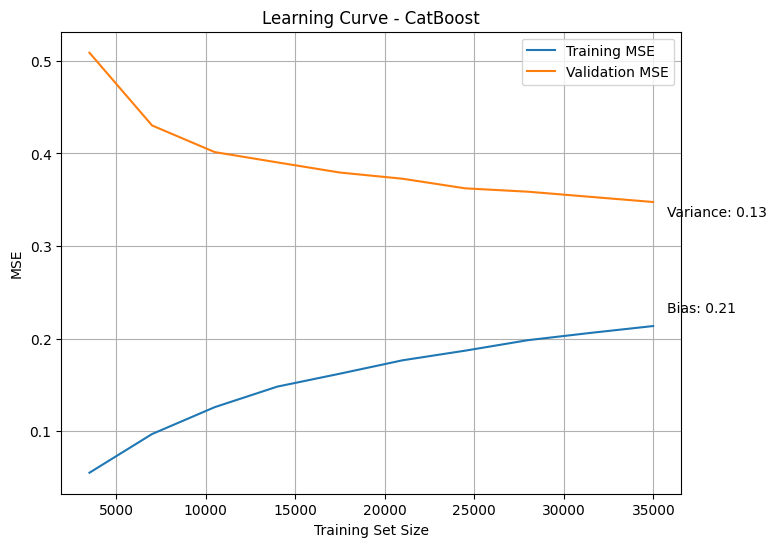

In [58]:
final_model = CatBoostRegressor(
    random_state=42,
    verbose=False,
    task_type="CPU",
    max_bin=32,
    depth=6,
    iterations=1500,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bylevel=0.8,
    devices="0:1",
)
plot_learning_curve(final_model, model_name)

1. Final Training MSE: 0.21 (low bias)
2. Final Validation MSE: 0.34 (0.21 + 0.13 variance)
3. Optimal Data Size: ~20,000 samples (improvement plateaus beyond this)

- Rapid Learning: 30% error reduction in first 15,000 samples
- Strong Generalization: Small train-val gap (0.13 MSE difference)
- Ideal for Medium Data: Peak performance at 20,000 samples

* Diminishing Returns: Minimal improvement beyond 20k samples
* Parameter Sensitivity : Requires careful hyperparameter tuning


In [19]:
models = {
    "Decision Tree": DecisionTreeRegressor(max_depth=14),
    "Random Forest": RandomForestRegressor(
        n_estimators=10, max_depth=22, random_state=42
    ),
    "SVR": SVR(C=1, epsilon=0.5, kernel="linear"),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=250, random_state=42),
    "CatBoost": CatBoostRegressor(
        random_state=42,
        verbose=False,
        task_type="CPU",
        max_bin=32,
        depth=6,
        iterations=1500,
    ),
}

results = []

for name, model in tqdm(models.items(), desc="Evaluating models"):
    mse_list = []
    train_time_list = []
    predict_time_list = []

    for i in range(4):
        # Training
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Prediction
        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_time = time.time() - start_time

        # Evaluation
        mse = mean_squared_error(y_test, y_pred)

        # Store
        mse_list.append(mse)
        train_time_list.append(training_time)
        predict_time_list.append(prediction_time)

    results.append(
        [
            name,
            round(np.mean(mse_list), 4),
            round(np.mean(train_time_list), 4),
            round(np.mean(predict_time_list), 4),
        ]
    )

# Create table
df_results = pd.DataFrame(
    results,
    columns=[
        "Model",
        "Average MSE (Evaluation Metric)",
        "Average Training Time (s)",
        "Average Prediction Time (s)",
    ],
)

print(df_results)

Evaluating models: 100%|██████████| 5/5 [34:11<00:00, 410.31s/it]

               Model  Average MSE (Evaluation Metric)  \
0      Decision Tree                           0.3910   
1      Random Forest                           0.3245   
2                SVR                           0.6985   
3  Gradient Boosting                           0.3472   
4           CatBoost                           0.3045   

   Average Training Time (s)  Average Prediction Time (s)  
0                     4.3135                       0.0077  
1                    34.1808                       0.0138  
2                    40.7070                       6.6785  
3                   414.6182                       0.0248  
4                    12.3143                       0.0180  


Among the evaluated models, CatBoost achieved the lowest MSE (0.3045), indicating the highest predictive accuracy, with a balanced bias-variance profile and moderate training time. Gradient Boosting also performed well but required significantly longer training (414.6s). SVR showed the highest error and bias despite a low variance, while Decision Tree and Random Forest offered reasonable trade-offs between performance and computational cost. Overall, CatBoost stands out as the most efficient and accurate model.


In [30]:
# Saving model
catboost_model = models["CatBoost"]
models_path = "../models/catboost_model.joblib"
joblib.dump(catboost_model, models_path)

['../models/catboost_model.joblib']